<a href="https://colab.research.google.com/github/dineshmanideep/captcha_cracknet/blob/Tanay/week_2_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import torch
import math
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

torch.cuda.is_available()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

torch.manual_seed(42)
torch.cuda.manual_seed(42)
class DynamicNet(nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate five parameters and assign them as members.
        """
        super().__init__()
        self.relu = nn.ReLU()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.relu(self.a)
        self.b = torch.nn.Parameter(torch.randn(()))
        self.relu(self.b)
        self.c = torch.nn.Parameter(torch.randn(()))
        self.relu(self.c)
        self.d = torch.nn.Parameter(torch.randn(()))
        self.relu(self.d)
        self.e = torch.nn.Parameter(torch.randn(()))
        self.relu(self.e)
        #self.linear_layer_stack = nn.Sequential(
          #nn.Linear(in_features=1,out_features=10),
          #nn.Linear(in_features=10,out_features=10),
          #nn.Linear(in_features=10,out_features=1)
    #)

    def forward(self, x):
        """
        For the forward pass of the model, we randomly choose either 4, 5
        and reuse the e parameter to compute the contribution of these orders.

        Since each forward pass builds a dynamic computation graph, we can use normal
        Python control-flow operators like loops or conditional statements when
        defining the forward pass of the model.

        Here we also see that it is perfectly safe to reuse the same parameter many
        times when defining a computational graph.
        """
        # Ensure all tensors are on the same device
        self.a = self.a.to(x.device)
        self.b = self.b.to(x.device)
        self.c = self.c.to(x.device)
        self.d = self.d.to(x.device)
        self.e = self.e.to(x.device)

        y = self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3
        for exp in range(4, random.randint(4, 6)):
            y = y + self.e * x ** exp
        return y

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3 + {self.e.item()} x^4 ? + {self.e.item()} x^5 ?'


# Create Tensors to hold input and outputs.
torch.manual_seed(42)
torch.cuda.manual_seed(42)
x = torch.linspace(-math.pi, math.pi, 2000).unsqueeze(dim=1)
y = torch.cos(x)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)
# Construct our model by instantiating the class defined above
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model = DynamicNet()
model.state_dict()
model.to(device) # Move the entire model to the device
next(model.parameters()).device

device(type='cpu')

In [2]:
list(model.parameters())

[Parameter containing:
 tensor(0.3367, requires_grad=True),
 Parameter containing:
 tensor(0.1288, requires_grad=True),
 Parameter containing:
 tensor(0.2345, requires_grad=True),
 Parameter containing:
 tensor(0.2303, requires_grad=True),
 Parameter containing:
 tensor(-1.1229, requires_grad=True)]

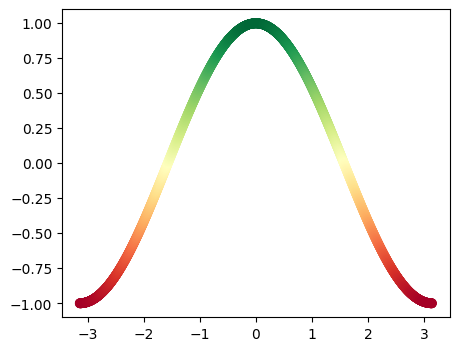

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(5,4))
plt.scatter(x,y,c=y,cmap=plt.cm.RdYlGn);

In [32]:
criterion=nn.MSELoss()
optimizer=torch.optim.RMSprop(params=model.parameters(),lr=0.0001)
losses = []
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 30000
epoch_count=[]
for t in range(epochs):
    model.train()
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x_train)

    # Compute and print loss
    loss = criterion(y_pred, y_train)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():#turns off gradient descent
      test_pred=model(x_test)
      test_loss=criterion(test_pred,y_test)
    if t % 5000 == 0:
        print(f"Epoch: {t} | Loss: {loss} | Test Loss: {test_loss}")
        losses.append(loss.item())
        epoch_count.append(t)


print(f'Result: {model.string()}')

Epoch: 0 | Loss: 0.03888588026165962 | Test Loss: 0.03968290239572525
Epoch: 5000 | Loss: 0.03872011601924896 | Test Loss: 0.036999598145484924
Epoch: 10000 | Loss: 0.03859153762459755 | Test Loss: 0.03784952312707901
Epoch: 15000 | Loss: 0.03788837790489197 | Test Loss: 0.03738313913345337
Epoch: 20000 | Loss: 0.037617579102516174 | Test Loss: 0.03809347748756409
Epoch: 25000 | Loss: 0.038666363805532455 | Test Loss: 0.03805240988731384
Result: y = 0.7671501040458679 + 0.005607333034276962 x + -0.2334803193807602 x^2 + -0.0019411626271903515 x^3 + 0.00046995107550174 x^4 ? + 0.00046995107550174 x^5 ?


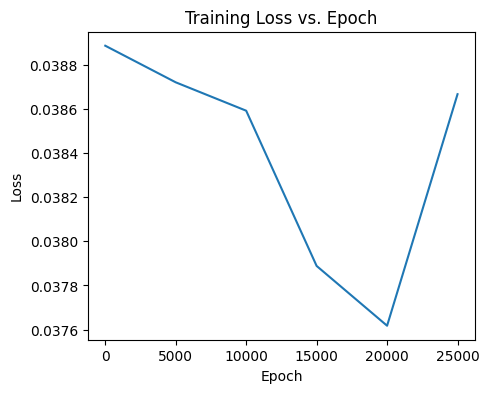

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(epochs,losses,predictions=None):
  plt.figure(figsize=(5,4))
  plt.plot(epoch_count, losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss vs. Epoch')
  plt.show()
plot_predictions(epochs,losses)

In [38]:
def plot_preds(train_data=x_train,train_labels=y_train,test_data=x_test,test_label=y_test,predictions=None):
    plt.figure(figsize=(10,7))
    #plot train data
    plt.scatter(train_data.cpu().numpy(),train_labels.cpu().numpy(),c="b",s=4,label="training data") # Convert tensors to NumPy arrays
    #plot test data
    plt.scatter(test_data.cpu().numpy(),test_label.cpu().numpy(),c="g",s=4,label="testing data") # Convert tensors to NumPy arrays

    #Are there predictions?
    if predictions is not None:
        # Detach predictions from the computation graph and convert to NumPy array
        predictions = predictions.detach().cpu().numpy()
        plt.scatter(test_data.cpu().numpy(), predictions, c="r", s=4, label="predictions")
    plt.legend(prop={"size":14})

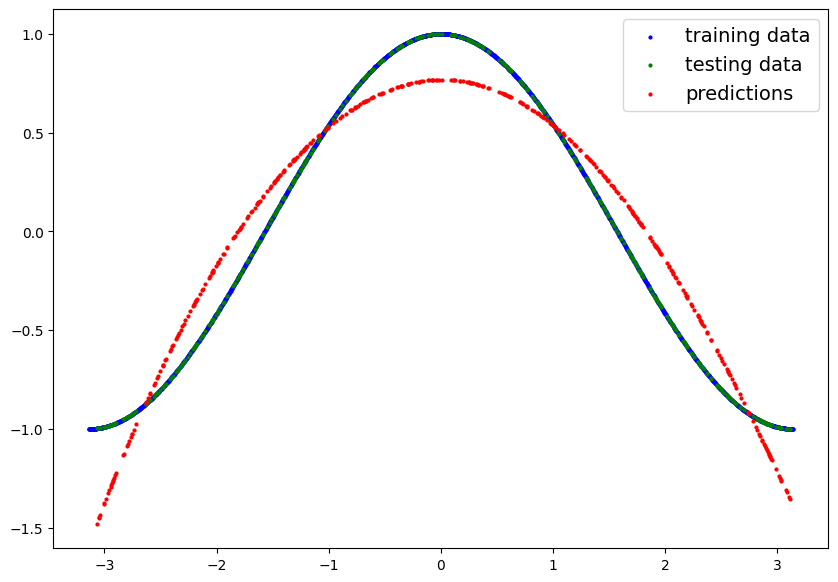

In [39]:
plot_preds(predictions=test_pred)